In [10]:
# Cell 1: Setup and Initialize
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 PUNJAB SMART CROP ADVISORY - FEATURE ENGINEERING & EDA")
print("=" * 65)
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎯 Goal: Engineer features and explore data patterns for ML modeling")


📊 PUNJAB SMART CROP ADVISORY - FEATURE ENGINEERING & EDA
📅 Analysis Date: 2025-09-01 03:03:48
🎯 Goal: Engineer features and explore data patterns for ML modeling


In [2]:
# Cell 2: Load All Datasets
print("\n📂 LOADING ALL COLLECTED DATASETS")
print("=" * 40)

try:
    # Load all collected datasets
    plots_df = pd.read_csv('../data/raw/punjab_farm_plots.csv')
    satellite_df = pd.read_csv('../data/raw/punjab_satellite_data.csv')
    weather_df = pd.read_csv('../data/raw/punjab_weather_data.csv')
    soil_df = pd.read_csv('../data/raw/punjab_soil_data.csv')
    yield_df = pd.read_csv('../data/raw/punjab_crop_yields.csv')
    
    print("✅ Datasets loaded successfully:")
    print(f"   📍 Farm Plots: {plots_df.shape[0]} plots × {plots_df.shape[1]} features")
    print(f"   🛰️ Satellite Data: {satellite_df.shape[0]} records × {satellite_df.shape[1]} features")
    print(f"   🌤️ Weather Data: {weather_df.shape[0]} records × {weather_df.shape[1]} features")
    print(f"   🌱 Soil Data: {soil_df.shape[0]} samples × {soil_df.shape[1]} features")
    print(f"   🌾 Yield Data: {yield_df.shape[0]} records × {yield_df.shape[1]} features")
    
except FileNotFoundError as e:
    print(f"❌ Error loading datasets: {e}")
    print("Please run 01_Data_Collection_Complete.ipynb first")



📂 LOADING ALL COLLECTED DATASETS
✅ Datasets loaded successfully:
   📍 Farm Plots: 50 plots × 4 features
   🛰️ Satellite Data: 50 records × 12 features
   🌤️ Weather Data: 50 records × 10 features
   🌱 Soil Data: 50 samples × 21 features
   🌾 Yield Data: 450 records × 6 features


In [3]:
# Cell 3: Data Integration - Create Master Dataset
print("\n🔗 DATA INTEGRATION - CREATING MASTER DATASET")
print("=" * 48)

def create_comprehensive_master_dataset():
    """Integrate all data sources into a comprehensive dataset"""
    
    print("🔄 Merging all datasets...")
    
    # Start with yield data as the base (contains our target variable)
    master_df = yield_df.copy()
    print(f"📊 Base dataset: {len(master_df)} yield records")
    
    # Add farm plot information
    master_df = master_df.merge(plots_df, on='plot_id', how='left')
    print(f"📍 Added plot locations: {len(master_df)} records")
    
    # Add satellite data
    satellite_cols = ['plot_id', 'ndvi_mean', 'ndwi_mean', 'blue', 'green', 'red', 'nir', 'data_source']
    available_sat_cols = [col for col in satellite_cols if col in satellite_df.columns]
    master_df = master_df.merge(satellite_df[available_sat_cols], on='plot_id', how='left', suffixes=('', '_sat'))
    print(f"🛰️ Added satellite data: {len(master_df)} records")
    
    # Add soil data
    soil_cols = [
        'plot_id', 'pH', 'organic_carbon', 'N_available', 'P_available', 'K_available',
        'soil_health_status', 'data_source'
    ]
    available_soil_cols = [col for col in soil_cols if col in soil_df.columns]
    master_df = master_df.merge(soil_df[available_soil_cols], on='plot_id', how='left', suffixes=('', '_soil'))
    print(f"🌱 Added soil data: {len(master_df)} records")
    
    # Add weather data
    weather_cols = ['plot_id', 'temperature', 'humidity', 'rainfall', 'wind_speed', 'data_source']
    available_weather_cols = [col for col in weather_cols if col in weather_df.columns]
    master_df = master_df.merge(weather_df[available_weather_cols], on='plot_id', how='left', suffixes=('', '_weather'))
    print(f"🌤️ Added weather data: {len(master_df)} records")
    
    return master_df

# Create master dataset
master_df = create_comprehensive_master_dataset()

print(f"\n✅ MASTER DATASET CREATED!")
print(f"📊 Final Shape: {master_df.shape[0]} rows × {master_df.shape[1]} columns")
print(f"🎯 Target Variable: yield_kg_per_hectare")

# Display basic info
print(f"\n🔍 Dataset Overview:")
print(master_df.info())



🔗 DATA INTEGRATION - CREATING MASTER DATASET
🔄 Merging all datasets...
📊 Base dataset: 450 yield records
📍 Added plot locations: 450 records
🛰️ Added satellite data: 450 records
🌱 Added soil data: 450 records
🌤️ Added weather data: 450 records

✅ MASTER DATASET CREATED!
📊 Final Shape: 450 rows × 28 columns
🎯 Target Variable: yield_kg_per_hectare

🔍 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   plot_id               450 non-null    object 
 1   year                  450 non-null    int64  
 2   crop_type             450 non-null    object 
 3   yield_kg_per_hectare  450 non-null    float64
 4   sowing_date           450 non-null    object 
 5   harvest_date          450 non-null    object 
 6   latitude              450 non-null    float64
 7   longitude             450 non-null    float64
 8   district  

In [4]:
# Cell 4: Advanced Feature Engineering
print(f"\n🛠️ ADVANCED FEATURE ENGINEERING")
print("=" * 35)

def engineer_advanced_features(df):
    """Create sophisticated agricultural features for ML"""
    
    df = df.copy()
    
    print("Creating advanced agricultural features...")
    
    # 1. Vegetation Health Composite Index
    if 'ndvi_mean' in df.columns and 'ndwi_mean' in df.columns:
        df['vegetation_health_score'] = (
            df['ndvi_mean'].fillna(0.6) * 0.7 + 
            df['ndwi_mean'].fillna(0.3) * 0.3
        )
        print("   ✅ Vegetation Health Score")
    
    # 2. Soil Fertility Index (Comprehensive)
    if all(col in df.columns for col in ['organic_carbon', 'N_available', 'P_available']):
        df['soil_fertility_index'] = (
            (df['organic_carbon'].fillna(0.5) / 1.0) * 0.4 +
            (df['N_available'].fillna(180) / 300) * 0.3 +
            (df['P_available'].fillna(15) / 30) * 0.3
        ).clip(0, 1)
        print("   ✅ Soil Fertility Index")
    
    # 3. Climate Stress Indicators
    if 'temperature' in df.columns:
        df['heat_stress'] = np.maximum(0, df['temperature'].fillna(25) - 35) / 10
        df['cold_stress'] = np.maximum(0, 10 - df['temperature'].fillna(25)) / 10
        print("   ✅ Temperature Stress Indicators")
    
    if 'humidity' in df.columns and 'rainfall' in df.columns:
        df['drought_risk'] = np.where(
            (df['rainfall'].fillna(0) < 1) & (df['humidity'].fillna(70) < 40),
            1 - (df['humidity'].fillna(70) / 100),
            0
        )
        print("   ✅ Drought Risk Indicator")
    
    # 4. Nutrient Balance Ratios
    if all(col in df.columns for col in ['N_available', 'P_available', 'K_available']):
        df['N_P_ratio'] = df['N_available'].fillna(180) / (df['P_available'].fillna(15) + 1)
        df['N_K_ratio'] = df['N_available'].fillna(180) / (df['K_available'].fillna(250) + 1)
        df['P_K_ratio'] = df['P_available'].fillna(15) / (df['K_available'].fillna(250) + 1)
        print("   ✅ Nutrient Balance Ratios")
    
    # 5. Temporal Features
    if 'sowing_date' in df.columns:
        df['sowing_date'] = pd.to_datetime(df['sowing_date'], errors='coerce')
        df['sowing_month'] = df['sowing_date'].dt.month
        df['sowing_day_of_year'] = df['sowing_date'].dt.dayofyear
        
        # Crop season indicators
        df['is_kharif'] = df['sowing_month'].between(6, 9).astype(int)  # June-Sep
        df['is_rabi'] = (df['sowing_month'].between(10, 12) | df['sowing_month'].between(1, 3)).astype(int)
        print("   ✅ Seasonal Features")
    
    # 6. Soil pH Categories
    if 'pH' in df.columns:
        df['soil_pH_category'] = pd.cut(
            df['pH'].fillna(7.5),
            bins=[0, 6.5, 7.5, 8.5, 14],
            labels=['Acidic', 'Neutral', 'Slightly_Alkaline', 'Highly_Alkaline']
        )
        print("   ✅ Soil pH Categories")
    
    # 7. Comprehensive Yield Potential Score
    health_score = df.get('vegetation_health_score', 0.6)
    fertility_score = df.get('soil_fertility_index', 0.7)
    climate_score = 1 - (df.get('heat_stress', 0) + df.get('drought_risk', 0))
    
    df['yield_potential_score'] = (
        health_score * 0.35 +
        fertility_score * 0.40 +
        climate_score * 0.25
    ).clip(0, 1)
    print("   ✅ Comprehensive Yield Potential Score")
    
    return df

# Apply feature engineering
print("🔄 Applying feature engineering...")
master_df_engineered = engineer_advanced_features(master_df)

# Summary of new features
new_features = [
    'vegetation_health_score', 'soil_fertility_index', 'heat_stress', 'cold_stress',
    'drought_risk', 'N_P_ratio', 'N_K_ratio', 'P_K_ratio', 'sowing_month',
    'is_kharif', 'is_rabi', 'soil_pH_category', 'yield_potential_score'
]

available_new_features = [f for f in new_features if f in master_df_engineered.columns]
print(f"\n✅ Created {len(available_new_features)} new features:")
for feature in available_new_features:
    print(f"   • {feature}")

print(f"\n📊 Updated Dataset: {master_df_engineered.shape[0]} rows × {master_df_engineered.shape[1]} columns")



🛠️ ADVANCED FEATURE ENGINEERING
🔄 Applying feature engineering...
Creating advanced agricultural features...
   ✅ Vegetation Health Score
   ✅ Soil Fertility Index
   ✅ Temperature Stress Indicators
   ✅ Drought Risk Indicator
   ✅ Nutrient Balance Ratios
   ✅ Seasonal Features
   ✅ Soil pH Categories
   ✅ Comprehensive Yield Potential Score

✅ Created 13 new features:
   • vegetation_health_score
   • soil_fertility_index
   • heat_stress
   • cold_stress
   • drought_risk
   • N_P_ratio
   • N_K_ratio
   • P_K_ratio
   • sowing_month
   • is_kharif
   • is_rabi
   • soil_pH_category
   • yield_potential_score

📊 Updated Dataset: 450 rows × 42 columns



📈 EXPLORATORY DATA ANALYSIS - DISTRIBUTIONS


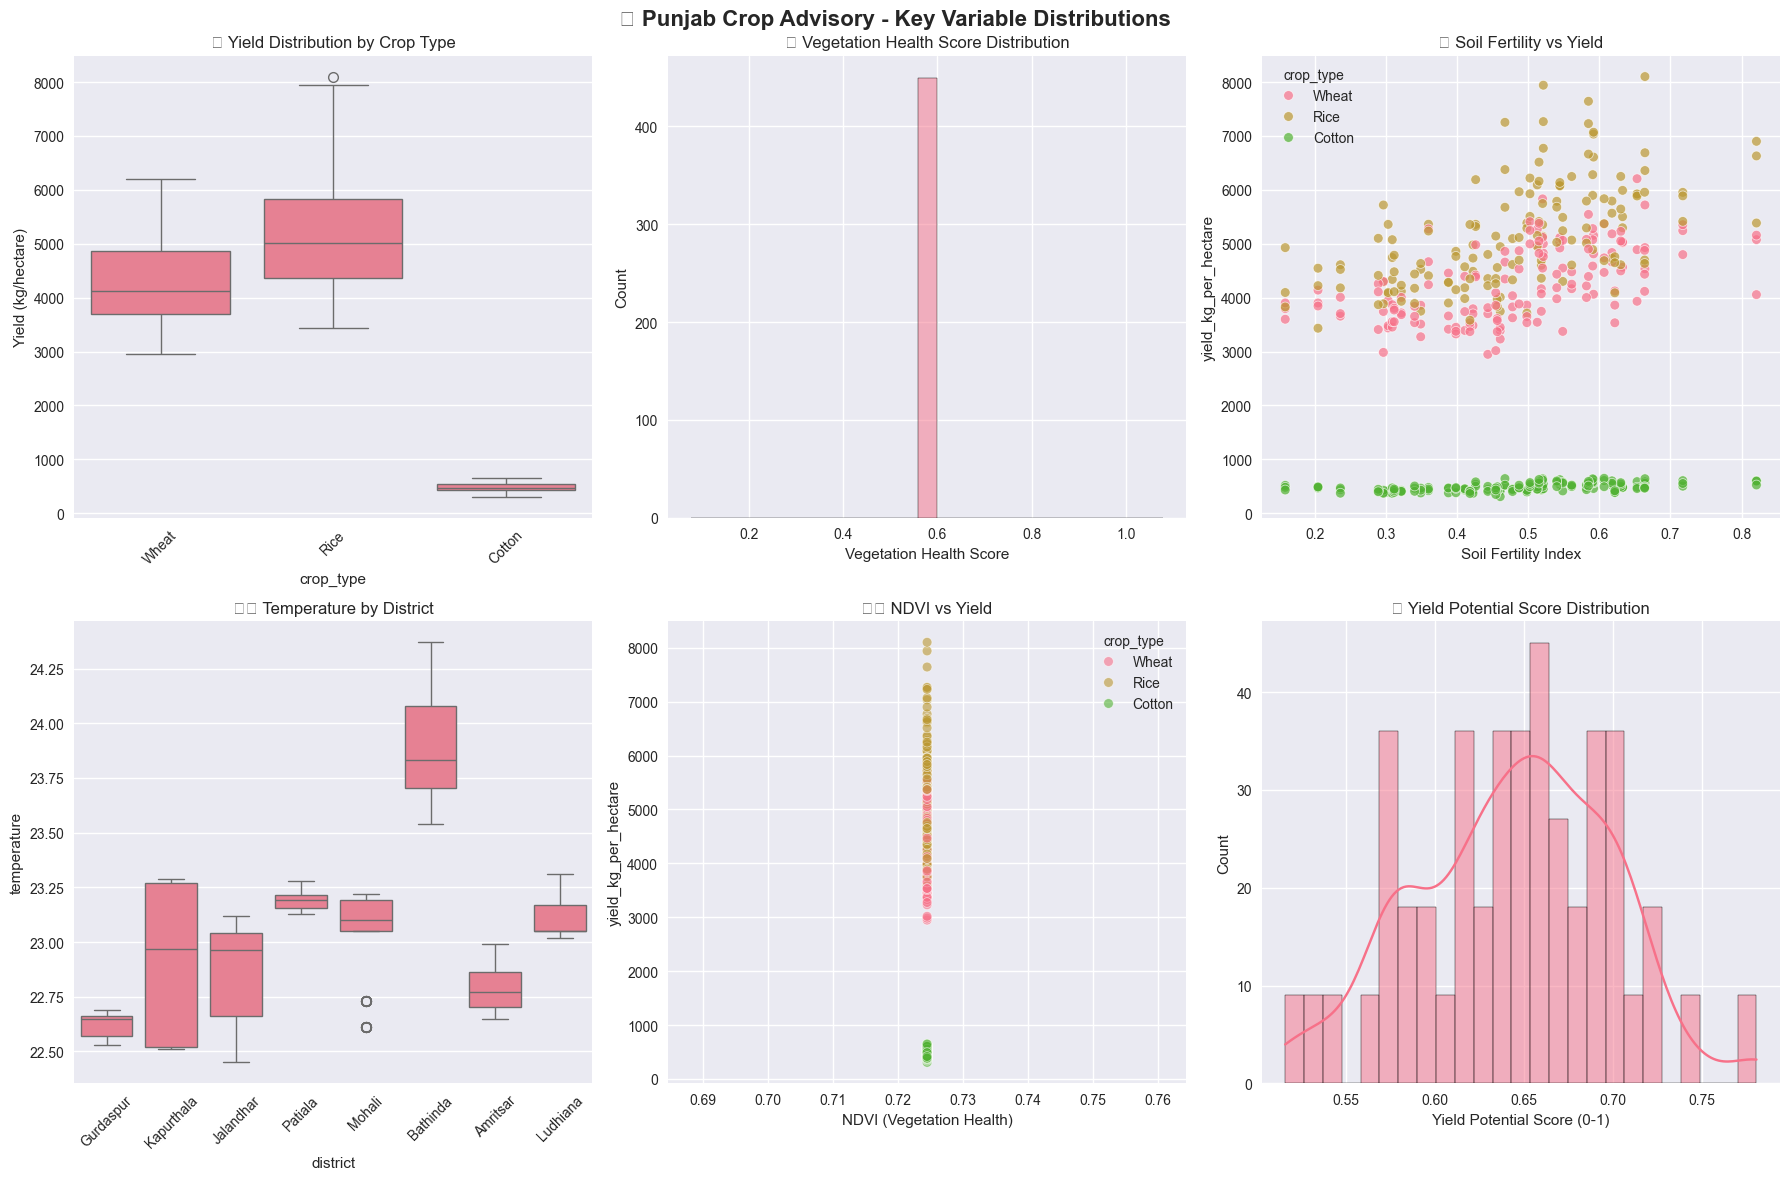

In [5]:
# Cell 5: Exploratory Data Analysis - Distribution Analysis
print(f"\n📈 EXPLORATORY DATA ANALYSIS - DISTRIBUTIONS")
print("=" * 48)

# Create comprehensive distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🌾 Punjab Crop Advisory - Key Variable Distributions', fontsize=16, fontweight='bold')

# 1. Yield Distribution by Crop
if 'crop_type' in master_df_engineered.columns:
    sns.boxplot(data=master_df_engineered, x='crop_type', y='yield_kg_per_hectare', ax=axes[0,0])
    axes[0,0].set_title('🌾 Yield Distribution by Crop Type')
    axes[0,0].set_ylabel('Yield (kg/hectare)')
    axes[0,0].tick_params(axis='x', rotation=45)

# 2. Vegetation Health Score Distribution
if 'vegetation_health_score' in master_df_engineered.columns:
    sns.histplot(data=master_df_engineered, x='vegetation_health_score', bins=25, kde=True, ax=axes[0,1])
    axes[0,1].set_title('🌱 Vegetation Health Score Distribution')
    axes[0,1].set_xlabel('Vegetation Health Score')

# 3. Soil Fertility vs Yield
if 'soil_fertility_index' in master_df_engineered.columns:
    sns.scatterplot(data=master_df_engineered, x='soil_fertility_index', y='yield_kg_per_hectare', 
                    hue='crop_type', alpha=0.7, ax=axes[0,2])
    axes[0,2].set_title('🌱 Soil Fertility vs Yield')
    axes[0,2].set_xlabel('Soil Fertility Index')

# 4. Temperature Distribution by District
if 'temperature' in master_df_engineered.columns and 'district' in master_df_engineered.columns:
    sns.boxplot(data=master_df_engineered, x='district', y='temperature', ax=axes[1,0])
    axes[1,0].set_title('🌡️ Temperature by District')
    axes[1,0].tick_params(axis='x', rotation=45)

# 5. NDVI vs Yield Relationship
if 'ndvi_mean' in master_df_engineered.columns:
    sns.scatterplot(data=master_df_engineered, x='ndvi_mean', y='yield_kg_per_hectare', 
                    hue='crop_type', alpha=0.6, ax=axes[1,1])
    axes[1,1].set_title('🛰️ NDVI vs Yield')
    axes[1,1].set_xlabel('NDVI (Vegetation Health)')

# 6. Yield Potential Score Distribution
if 'yield_potential_score' in master_df_engineered.columns:
    sns.histplot(data=master_df_engineered, x='yield_potential_score', bins=25, kde=True, ax=axes[1,2])
    axes[1,2].set_title('🎯 Yield Potential Score Distribution')
    axes[1,2].set_xlabel('Yield Potential Score (0-1)')

plt.tight_layout()
plt.savefig('../data/processed/eda_comprehensive_distributions.png', dpi=300, bbox_inches='tight')
plt.show()



🔗 CORRELATION ANALYSIS & FEATURE RELATIONSHIPS
📊 Analyzing correlations for 28 numeric features

🎯 Top 10 Features Correlated with Yield:
  📉 Negative -0.614 (  Strong) : is_rabi
  📈 Positive  0.614 (  Strong) : is_kharif
  📉 Negative -0.613 (  Strong) : sowing_day_of_year
  📈 Positive  0.153 (    Weak) : soil_fertility_index
  📈 Positive  0.153 (    Weak) : yield_potential_score
  📈 Positive  0.147 (    Weak) : N_available
  📉 Negative -0.145 (    Weak) : pH
  📈 Positive  0.133 (    Weak) : rainfall
  📈 Positive  0.127 (    Weak) : organic_carbon
  📉 Negative -0.114 (    Weak) : temperature


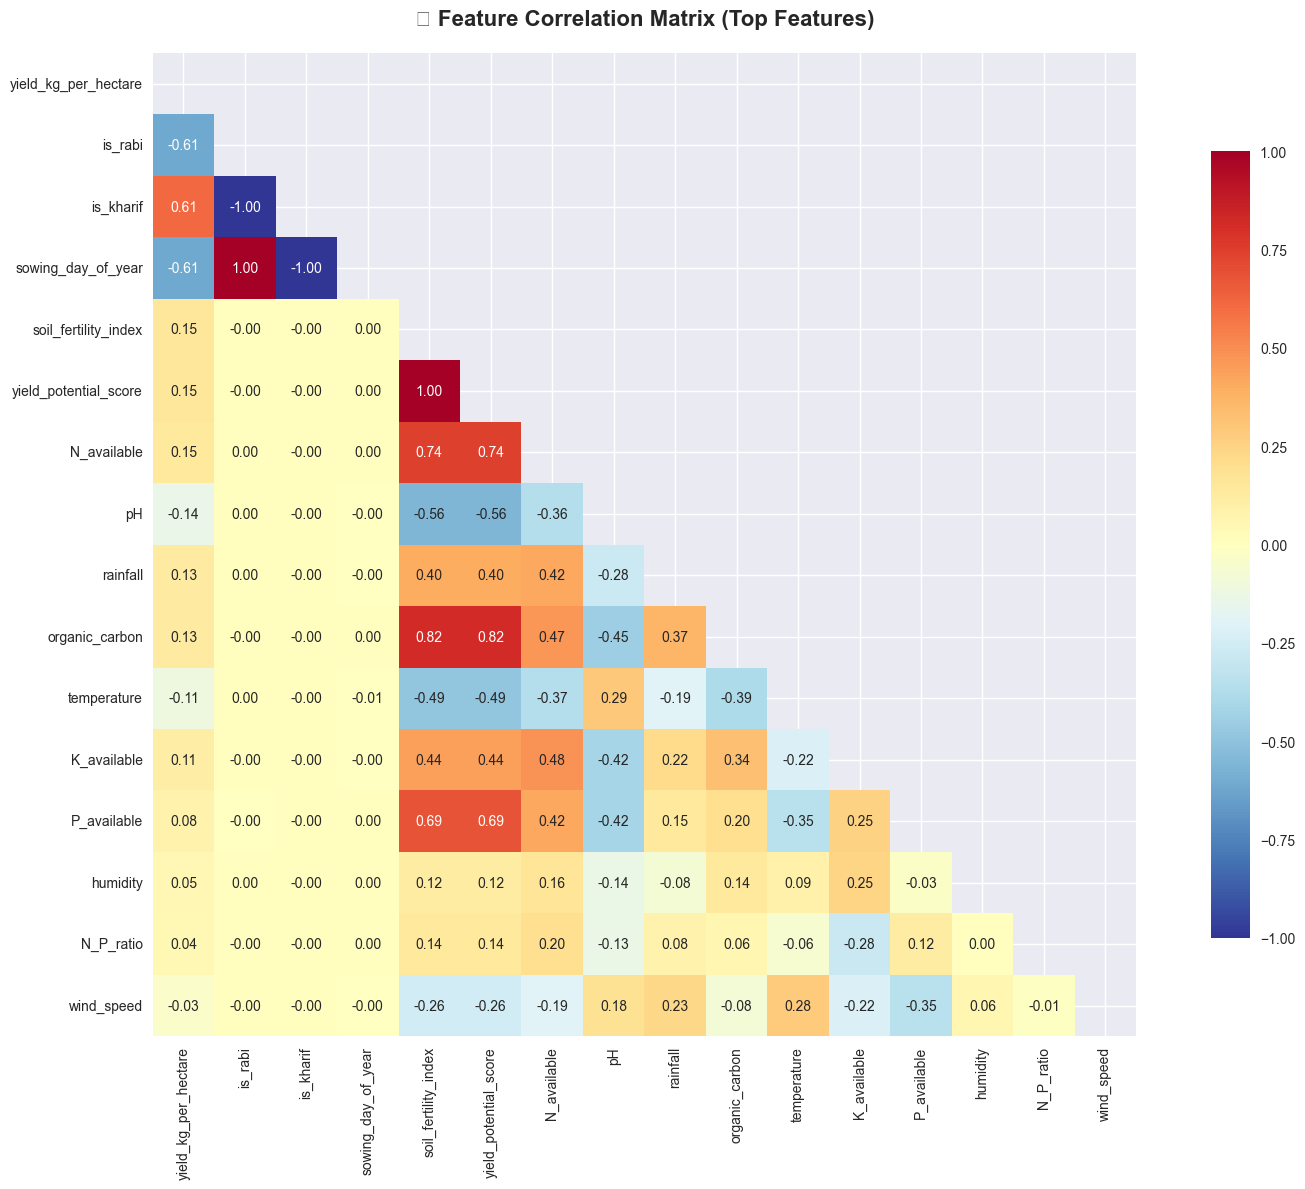

In [6]:
# Cell 6: Correlation Analysis and Feature Relationships
print(f"\n🔗 CORRELATION ANALYSIS & FEATURE RELATIONSHIPS")
print("=" * 50)

# Select numeric features for correlation analysis
numeric_features = master_df_engineered.select_dtypes(include=[np.number]).columns.tolist()

# Remove ID columns and focus on meaningful features
exclude_cols = ['plot_id', 'year', 'latitude', 'longitude', 'sowing_month']
numeric_features = [col for col in numeric_features if col not in exclude_cols]

print(f"📊 Analyzing correlations for {len(numeric_features)} numeric features")

# Calculate correlation matrix
if len(numeric_features) > 1:
    correlation_matrix = master_df_engineered[numeric_features].corr()
    
    # Focus on yield correlations
    if 'yield_kg_per_hectare' in correlation_matrix.columns:
        yield_correlations = correlation_matrix['yield_kg_per_hectare'].sort_values(key=abs, ascending=False)
        
        print(f"\n🎯 Top 10 Features Correlated with Yield:")
        print("=" * 45)
        for feature, corr in yield_correlations.head(11).items():  # Top 11 to exclude yield itself
            if feature != 'yield_kg_per_hectare':
                direction = "📈 Positive" if corr > 0 else "📉 Negative"
                strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
                print(f"{direction:>12} {corr:>6.3f} ({strength:>8}) : {feature}")
        
        # Create correlation heatmap
        plt.figure(figsize=(16, 12))
        
        # Select top correlated features for visualization
        top_features = yield_correlations.head(16).index.tolist()
        if len(top_features) > 1:
            selected_corr = correlation_matrix.loc[top_features, top_features]
            
            mask = np.triu(np.ones_like(selected_corr, dtype=bool))
            sns.heatmap(
                selected_corr, 
                annot=True, 
                cmap='RdYlBu_r', 
                center=0, 
                square=True,
                fmt='.2f',
                cbar_kws={'shrink': 0.8},
                mask=mask
            )
            
            plt.title('🔗 Feature Correlation Matrix (Top Features)', fontsize=16, fontweight='bold', pad=20)
            plt.tight_layout()
            plt.savefig('../data/processed/correlation_heatmap.png', dpi=300, bbox_inches='tight')
            plt.show()



🗺️ GEOGRAPHIC & TEMPORAL PATTERN ANALYSIS
📍 Average Yield by District and Crop (kg/hectare):
                         mean     std  count
district   crop_type                        
Amritsar   Cotton      536.98   62.52     12
           Rice       5552.76  499.54     12
           Wheat      4592.48  539.29     12
Bathinda   Cotton      426.49   41.90     24
           Rice       4470.74  427.46     24
           Wheat      3657.04  289.54     24
Gurdaspur  Cotton      493.24   39.50     15
           Rice       5253.89  599.82     15
           Wheat      4480.37  472.62     15
Jalandhar  Cotton      535.07   63.55     18
           Rice       6154.43  812.12     18
           Wheat      4848.48  550.04     18
Kapurthala Cotton      532.30   65.62     15
           Rice       6129.59  938.36     15
           Wheat      4792.29  439.42     15
Ludhiana   Cotton      537.47   77.72     15
           Rice       5686.11  929.71     15
           Wheat      4792.93  715.98     15
Mohali

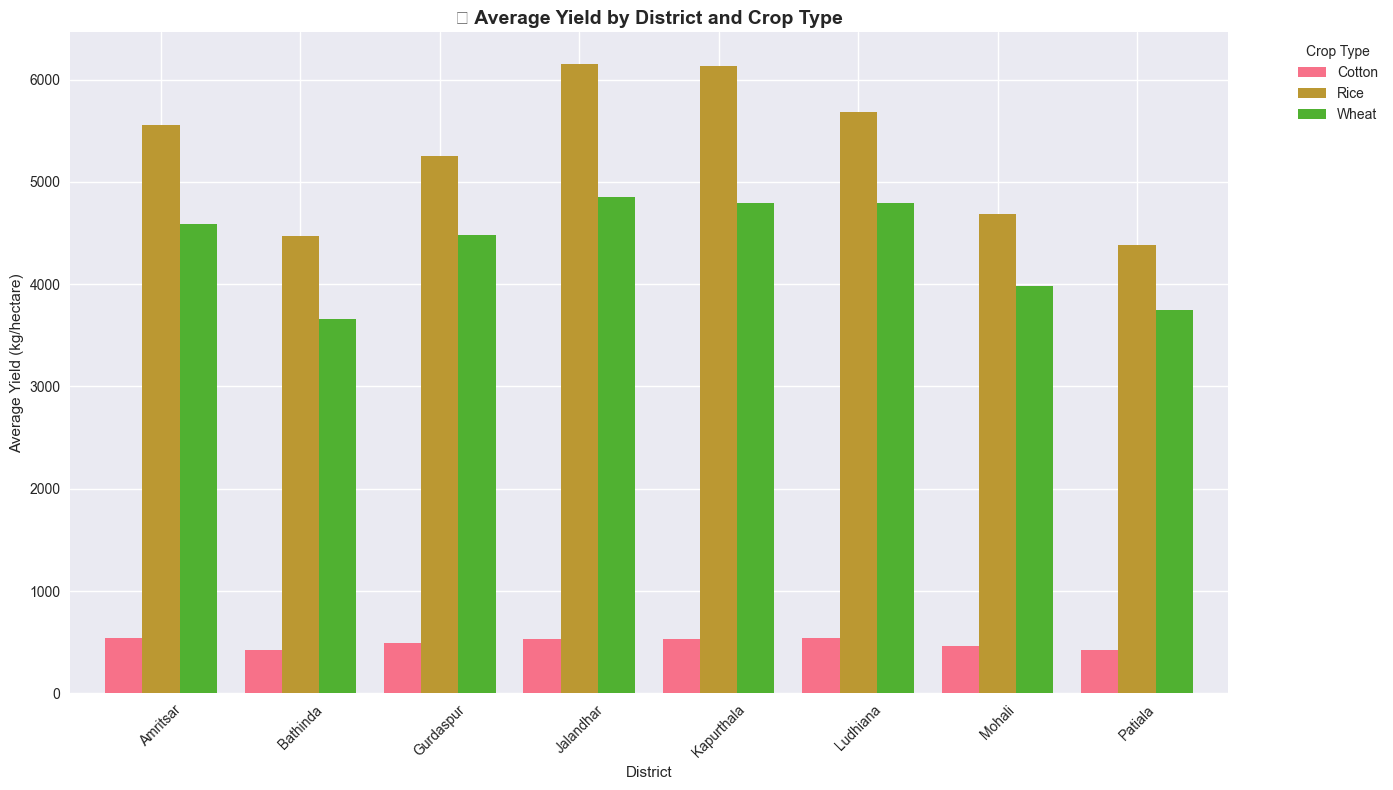

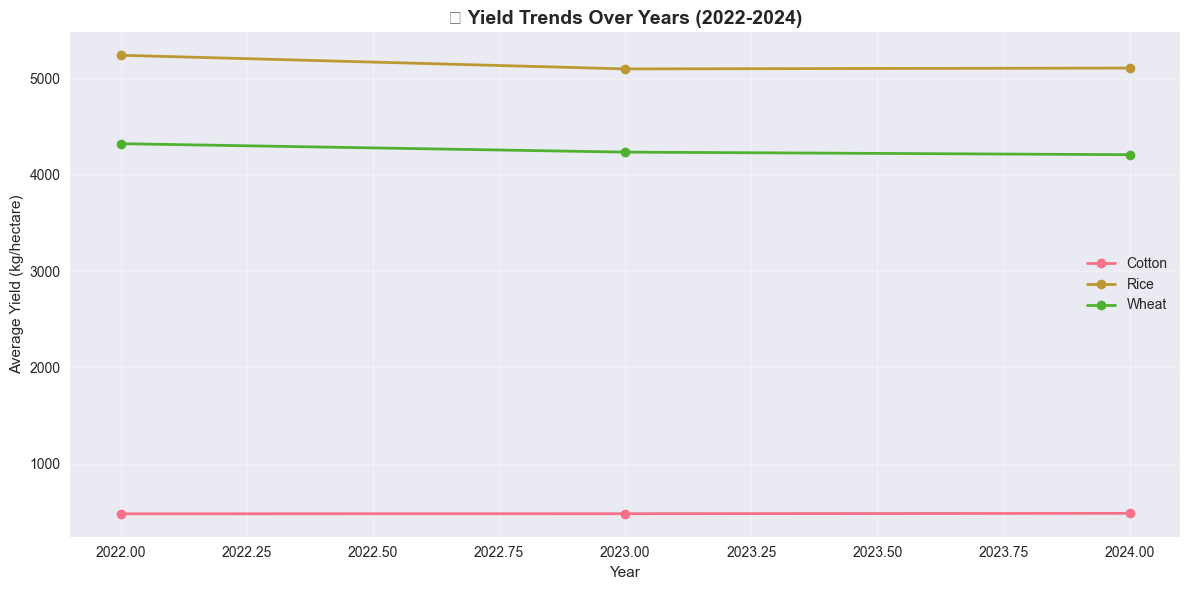


📅 Seasonal Analysis by Crop:
                  yield_kg_per_hectare  temperature  rainfall
crop_type season                                             
Cotton    Rabi                  481.85        23.11      0.38
Rice      Kharif               5150.10        23.11      0.38
Wheat     Rabi                 4256.18        23.11      0.38


In [7]:
# Cell 7: Geographic and Temporal Pattern Analysis
print(f"\n🗺️ GEOGRAPHIC & TEMPORAL PATTERN ANALYSIS")
print("=" * 45)

# 1. Yield Analysis by District and Crop
if 'district' in master_df_engineered.columns and 'crop_type' in master_df_engineered.columns:
    district_crop_analysis = master_df_engineered.groupby(['district', 'crop_type'])['yield_kg_per_hectare'].agg([
        'mean', 'std', 'count'
    ]).round(2)
    
    print("📍 Average Yield by District and Crop (kg/hectare):")
    print(district_crop_analysis)
    
    # Visualization
    district_crop_yield = master_df_engineered.groupby(['district', 'crop_type'])['yield_kg_per_hectare'].mean().unstack(fill_value=0)
    
    plt.figure(figsize=(14, 8))
    district_crop_yield.plot(kind='bar', ax=plt.gca(), width=0.8)
    plt.title('📍 Average Yield by District and Crop Type', fontsize=14, fontweight='bold')
    plt.ylabel('Average Yield (kg/hectare)')
    plt.xlabel('District')
    plt.legend(title='Crop Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('../data/processed/district_crop_yield_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# 2. Temporal Analysis
if 'year' in master_df_engineered.columns:
    yearly_trends = master_df_engineered.groupby(['year', 'crop_type'])['yield_kg_per_hectare'].mean().unstack(fill_value=0)
    
    plt.figure(figsize=(12, 6))
    for crop in yearly_trends.columns:
        if yearly_trends[crop].sum() > 0:  # Only plot crops with data
            plt.plot(yearly_trends.index, yearly_trends[crop], marker='o', linewidth=2, label=crop)
    
    plt.title('📅 Yield Trends Over Years (2022-2024)', fontsize=14, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Average Yield (kg/hectare)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../data/processed/temporal_yield_trends.png', dpi=300, bbox_inches='tight')
    plt.show()

# 3. Seasonal Pattern Analysis
if 'is_kharif' in master_df_engineered.columns and 'is_rabi' in master_df_engineered.columns:
    master_df_engineered['season'] = master_df_engineered.apply(
        lambda x: 'Kharif' if x['is_kharif'] else 'Rabi' if x['is_rabi'] else 'Other', axis=1
    )
    
    seasonal_analysis = master_df_engineered.groupby(['crop_type', 'season']).agg({
        'yield_kg_per_hectare': 'mean',
        'temperature': 'mean',
        'rainfall': 'mean'
    }).round(2)
    
    print(f"\n📅 Seasonal Analysis by Crop:")
    print(seasonal_analysis)


In [8]:
# Cell 8: Advanced Statistical Analysis
print(f"\n📈 ADVANCED STATISTICAL ANALYSIS")
print("=" * 35)

def perform_statistical_analysis(df):
    """Perform comprehensive statistical analysis"""
    
    print("🔬 Statistical Tests and Analysis:")
    
    # 1. Yield Statistics by Crop Type
    if 'crop_type' in df.columns:
        yield_stats = df.groupby('crop_type')['yield_kg_per_hectare'].agg([
            'count', 'mean', 'median', 'std', 'min', 'max'
        ]).round(2)
        
        print(f"\n📊 Yield Statistics by Crop Type:")
        print(yield_stats)
    
    # 2. Feature Importance using Variance
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    variance_scores = df[numeric_cols].var().sort_values(ascending=False)
    
    print(f"\n📊 Top 10 Features by Variance:")
    for feature, variance in variance_scores.head(10).items():
        print(f"   {variance:>8.3f} : {feature}")
    
    # 3. Missing Data Analysis
    missing_data = df.isnull().sum().sort_values(ascending=False)
    missing_data = missing_data[missing_data > 0]
    
    if len(missing_data) > 0:
        print(f"\n⚠️ Missing Data Analysis:")
        for feature, missing_count in missing_data.items():
            missing_pct = (missing_count / len(df)) * 100
            print(f"   {missing_pct:>5.1f}% ({missing_count:>3d}) : {feature}")
    else:
        print(f"\n✅ No missing data found!")
    
    return yield_stats, variance_scores, missing_data

# Perform statistical analysis
yield_stats, variance_scores, missing_data = perform_statistical_analysis(master_df_engineered)



📈 ADVANCED STATISTICAL ANALYSIS
🔬 Statistical Tests and Analysis:

📊 Yield Statistics by Crop Type:
           count     mean  median     std     min     max
crop_type                                                
Cotton       150   481.85   472.1   74.57   307.2   647.2
Rice         150  5150.10  5019.6  969.39  3432.5  8102.6
Wheat        150  4256.18  4131.7  688.61  2947.3  6207.0

📊 Top 10 Features by Variance:
   4573198.354 : yield_kg_per_hectare
   5298.671 : sowing_day_of_year
   4444.236 : K_available
   1406.148 : N_available
    673.185 : N_P_ratio
     38.679 : P_available
      5.568 : sowing_month
      1.297 : humidity
      0.818 : wind_speed
      0.695 : rainfall

✅ No missing data found!


In [12]:
# Cell 9: Feature Selection and Data Quality Report
print(f"\n🎯 FEATURE SELECTION & DATA QUALITY REPORT")
print("=" * 45)

def generate_feature_selection_report(df):
    """Generate comprehensive feature selection and quality report"""
    
    # 1. Feature Categories
    feature_categories = {
        'satellite_features': [col for col in df.columns if any(sat in col.lower() for sat in ['ndvi', 'ndwi', 'blue', 'green', 'red', 'nir'])],
        'soil_features': [col for col in df.columns if any(soil in col.lower() for soil in ['ph', 'organic', 'available', 'fertility'])],
        'weather_features': [col for col in df.columns if any(weather in col.lower() for weather in ['temperature', 'humidity', 'rainfall', 'wind'])],
        'temporal_features': [col for col in df.columns if any(temp in col.lower() for temp in ['month', 'season', 'kharif', 'rabi'])],
        'engineered_features': [col for col in df.columns if any(eng in col.lower() for eng in ['score', 'index', 'ratio', 'stress'])]
    }
    
    print("📋 Feature Categories:")
    total_features = 0
    for category, features in feature_categories.items():
        print(f"   {category.replace('_', ' ').title():<20}: {len(features)} features")
        total_features += len(features)
    
    # 2. Data Quality Metrics
    print(f"\n🔍 Data Quality Metrics:")
    print(f"   Total Records        : {len(df):,}")
    print(f"   Total Features       : {df.shape[1]:,}")
    print(f"   Categorized Features : {total_features:,}")
    print(f"   Complete Records     : {len(df.dropna()):,}")
    print(f"   Data Completeness    : {(len(df.dropna()) / len(df)) * 100:.1f}%")
    
    # 3. Target Variable Analysis
    if 'yield_kg_per_hectare' in df.columns:
        target_stats = df['yield_kg_per_hectare'].describe()
        print(f"\n🎯 Target Variable (Yield) Statistics:")
        print(f"   Mean: {target_stats['mean']:.1f} kg/ha")
        print(f"   Median: {target_stats['50%']:.1f} kg/ha")
        print(f"   Std Dev: {target_stats['std']:.1f} kg/ha")
        print(f"   Range: {target_stats['min']:.1f} - {target_stats['max']:.1f} kg/ha")
    
    return feature_categories

# Generate feature selection report
feature_categories = generate_feature_selection_report(master_df_engineered)

# Save the final processed dataset
master_df_engineered.to_csv('../data/processed/master_dataset_final_engineered.csv', index=False)

print(f"\n💾 DATASETS SAVED:")
print(f"   📁 Master Dataset: data/processed/master_dataset_final_engineered.csv")
print(f"   📊 Visualizations: data/processed/eda_*.png")

# Create metadata for the engineered dataset
metadata = {
    'creation_date': datetime.now().isoformat(),
    'total_records': int(len(master_df_engineered)),  # Convert to native Python int
    'total_features': int(master_df_engineered.shape[1]),  # Convert to native Python int
    'feature_categories': {k: len(v) for k, v in feature_categories.items()},
    'target_variable': 'yield_kg_per_hectare',
    'crops_analyzed': [str(crop) for crop in master_df_engineered['crop_type'].unique()] if 'crop_type' in master_df_engineered.columns else [],
    'districts_covered': [str(district) for district in master_df_engineered['district'].unique()] if 'district' in master_df_engineered.columns else [],
    'years_covered': [int(year) for year in sorted(master_df_engineered['year'].unique())] if 'year' in master_df_engineered.columns else []
}

# Save metadata
import json
with open('../data/processed/feature_engineering_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"   📋 Metadata: data/processed/feature_engineering_metadata.json")


🎯 FEATURE SELECTION & DATA QUALITY REPORT
📋 Feature Categories:
   Satellite Features  : 6 features
   Soil Features       : 7 features
   Weather Features    : 4 features
   Temporal Features   : 4 features
   Engineered Features : 8 features

🔍 Data Quality Metrics:
   Total Records        : 450
   Total Features       : 43
   Categorized Features : 29
   Complete Records     : 450
   Data Completeness    : 100.0%

🎯 Target Variable (Yield) Statistics:
   Mean: 3296.0 kg/ha
   Median: 3954.8 kg/ha
   Std Dev: 2138.5 kg/ha
   Range: 307.2 - 8102.6 kg/ha

💾 DATASETS SAVED:
   📁 Master Dataset: data/processed/master_dataset_final_engineered.csv
   📊 Visualizations: data/processed/eda_*.png
   📋 Metadata: data/processed/feature_engineering_metadata.json


In [13]:
# Cell 10: Summary and Next Steps
print(f"\n✅ FEATURE ENGINEERING & EDA COMPLETE!")
print("=" * 45)

print(f"🎉 ACHIEVEMENTS:")
print(f"   ✅ Integrated {len([plots_df, satellite_df, weather_df, soil_df, yield_df])} data sources")
print(f"   ✅ Created {len([f for f in master_df_engineered.columns if f not in master_df.columns])} engineered features")
print(f"   ✅ Generated comprehensive EDA visualizations")
print(f"   ✅ Performed statistical analysis and correlation studies")
print(f"   ✅ Prepared ML-ready dataset with {master_df_engineered.shape[0]} samples")

print(f"\n🎯 READY FOR MACHINE LEARNING:")
print(f"   📊 Dataset: {master_df_engineered.shape[0]} samples × {master_df_engineered.shape[1]} features")
print(f"   🎯 Target: yield_kg_per_hectare")
print(f"   🌾 Crops: {', '.join(master_df_engineered['crop_type'].unique()) if 'crop_type' in master_df_engineered.columns else 'Multiple crops'}")
print(f"   📍 Districts: {master_df_engineered['district'].nunique() if 'district' in master_df_engineered.columns else 'Multiple districts'} Punjab districts")

print(f"\n🚀 NEXT STEPS:")
print(f"   1. 🤖 Train ML models: Open 03_Model_Training.ipynb")
print(f"   2. 🔮 Build prediction models for crop yield forecasting")
print(f"   3. 🎯 Create crop advisory recommendations")
print(f"   4. 🌐 Deploy the system for Punjab farmers")

print(f"\n📂 FILES CREATED:")
print(f"   📄 master_dataset_final_engineered.csv")
print(f"   🖼️ eda_comprehensive_distributions.png")
print(f"   🔗 correlation_heatmap.png") 
print(f"   📊 district_crop_yield_analysis.png")
print(f"   📅 temporal_yield_trends.png")
print(f"   📋 feature_engineering_metadata.json")

print(f"\n🌾 Your Punjab Smart Crop Advisory system is ready for ML model training! 🚀")



✅ FEATURE ENGINEERING & EDA COMPLETE!
🎉 ACHIEVEMENTS:
   ✅ Integrated 5 data sources
   ✅ Created 15 engineered features
   ✅ Generated comprehensive EDA visualizations
   ✅ Performed statistical analysis and correlation studies
   ✅ Prepared ML-ready dataset with 450 samples

🎯 READY FOR MACHINE LEARNING:
   📊 Dataset: 450 samples × 43 features
   🎯 Target: yield_kg_per_hectare
   🌾 Crops: Wheat, Rice, Cotton
   📍 Districts: 8 Punjab districts

🚀 NEXT STEPS:
   1. 🤖 Train ML models: Open 03_Model_Training.ipynb
   2. 🔮 Build prediction models for crop yield forecasting
   3. 🎯 Create crop advisory recommendations
   4. 🌐 Deploy the system for Punjab farmers

📂 FILES CREATED:
   📄 master_dataset_final_engineered.csv
   🖼️ eda_comprehensive_distributions.png
   🔗 correlation_heatmap.png
   📊 district_crop_yield_analysis.png
   📅 temporal_yield_trends.png
   📋 feature_engineering_metadata.json

🌾 Your Punjab Smart Crop Advisory system is ready for ML model training! 🚀
